En este proyecto vamos a seguir trabajando con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso es continuar con la limpieza de datos y avanzar en remover valores faltantes y remover outliers. Por otro lado, vamos a agregar nuevos atributos basados en los datos.

## Dataset: Propiedades en venta en Ciudad de Buenos Aires.

En este proyecto, trabajaremos con una muestra del conjunto de datos de propiedades en venta mencionado. En este dataset, cada fila es una propiedad en venta. A continuación vamos a describir los atributos que consideramos en esta muestra:

* id: id de la propiedad
* created_on: fecha en la que la propiedad ingresó al sitio
* operation: alquiler (rent) o venta (sell)
* property_type: tipo de propiedad (casa, departamento, ph, etcétera)
* place_with_parent_names: nombre del lugar donde se encuentra la propiedad según el publicador
* lat-lon: coordenadas concatenadas
* lat: latitud
* lon: longitud
* price: precio en la moneda especificada en currency
* currency: divisa en la que está expresada la publicación
* price_aprox_usd: precio aproximado en dólares estadounidenses
* surface_total_in_m2: superficie total (en metros cuadrados)
* surface_covered_in_m2: superficie cubierta (en metros cuadrados)
* price_usd_per_m2: precio por metro cuadrado en dólares (precio dólares / superficie)
* floor: número de piso (si corresponde)
* rooms: cantidad de ambientes
* expenses: expensas (si corresponde)
* barrio: barrio según cartografía oficial
* properati_url: url de la publicación en Properati

A continuación vamos a levantar el dataset para comenzar el procesamiento. Cabe destacar que en este caso ya fueron hechas las correcciones de coordenadas y superficies incorrectas que vimos en el proyecto anterior (https://github.com/fbarberis/ml_tests/blob/master/An%C3%A1lisis%20Exploratorio%20-%20Properati%20Bs.As..ipynb)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
 
sns.set_style("whitegrid")
sns.set_context("paper")

plt.rcParams['figure.figsize'] = (12,5)

In [2]:
path_dataset = 'dataset/datos_properati_limpios.csv'
df = pd.read_csv(path_dataset, parse_dates=['created_on'])

In [3]:
df.columns

Index(['created_on', 'operation', 'property_type', 'place_with_parent_names',
       'lat-lon', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms',
       'expenses', 'properati_url', 'barrio'],
      dtype='object')

In [4]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 18979 observaciones


Dado que ya lo trabajamos en el proyecto anterior, en este caso ya hemos filtrado observaciones para trabajar solo con casas (house), departamentos (apartment) y PH (PH).

### Outliers

Analicemos en primer lugar los valores extremos que puede haber en los precios y en las superficies. Esto nos va a ser útil para luego imputar usando medidas de tendencia central, como el promedio. 
Recordemos que las medidas de tendencia central pueden ser sensibles a outliers, por lo que la imputación de valores faltantes puede verse afectada

Una posible pregunta que surge es si conviene primero imputar faltantes y luego remover outliers, o lo contrario.  Cuando se imputa se modifica la distribución de los datos. Por eso, las cotas que utilicemos para definir los outliers se verán afectadas por este cambio y modificarán los resultados finales. Entonces comenzaremos quitando outliers.

Vamos a trabajar con `price_usd_per_m2`. Precios altos pueden corresponderse con grandes superficies, por lo que conviene analizar juntos ambos atributos. Veamos la distribución de los valores y un boxplot para comenzar a identificar los outliers.

Hacemos un `drop` de los valores `NaN` de esta columna antes de graficar.

In [5]:
df2 = df.dropna(subset=['price_usd_per_m2'])
df2.isna().sum()

created_on                     0
operation                      0
property_type                  0
place_with_parent_names        0
lat-lon                        0
                           ...  
floor                      13515
rooms                       3614
expenses                   12599
properati_url                  0
barrio                         0
Length: 16, dtype: int64

Hacemos un `boxplot` de la columna `price_usd_per_m2`

I:\Users\franc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


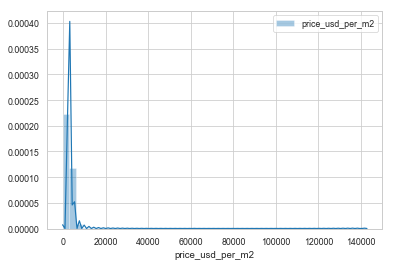

In [6]:
sns.distplot(df2.price_usd_per_m2, label= 'price_usd_per_m2')
plt.legend();

Para confirmar la presencia de outliers vamos a utilizar los percentiles.


In [7]:
df2.price_usd_per_m2.describe()

count     16037.000000
mean       2760.408525
std        1940.153216
min           0.958333
25%        1984.126984
50%        2545.454545
75%        3162.790698
max      142450.141026
Name: price_usd_per_m2, dtype: float64

Estamos ante la presencia de valores extremos en ambas puntas de la distribución. Vamos a aplicar la técnica del rango intercuartílico para limpiarlos.

Para obtener el rango tenemos que calcular la diferencia entre el tercer y el primer percentil. Luego en base a esto calcularemos los valores mínimos y máximos para definir qué observaciones serán descartadas.


In [8]:
q1 = df2['price_usd_per_m2'].quantile(q=0.25, interpolation='linear')
q3 = df2['price_usd_per_m2'].quantile(q=0.75, interpolation='linear')
iq = (q3 - q1)

print('Primer cuartil\t' + str(q1))
print('Segundo cuartil\t'+ str(q3))
print('Intercuartil\t'+ str(iq))

Primer cuartil	1984.1269841269839
Segundo cuartil	3162.7906976744184
Intercuartil	1178.6637135474346


In [9]:
min = q1-(1.5*iq)
max = q3+(1.5*iq)
df3=df2.loc[(df2['price_usd_per_m2'] > min) & (df2['price_usd_per_m2']<max)]
df3

,created_on,operation,property_type,place_with_parent_names,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,barrio
2,2017-08-02,sell,store,|Argentina|Capital Federal|Palermo|Palermo Soho|,"-34.589723,-58.4325664",-34.589723,-58.432566,343000.00,122.0,108.0,2811.475410,NaN,2.0,NaN,https://www.properati.com.ar/1cm8w_venta_local...,PALERMO
5,2017-08-09,sell,store,|Argentina|Capital Federal|Palermo|,"-34.57582474,-58.43432236",-34.575825,-58.434322,120000.00,30.0,30.0,4000.000000,1.0,NaN,NaN,https://www.properati.com.ar/1cw7a_venta_local...,PALERMO
6,2017-08-11,sell,store,|Argentina|Capital Federal|Belgrano|,"-34.5739059,-58.4391946",-34.573906,-58.439195,100000.00,26.0,NaN,3846.153846,NaN,NaN,NaN,https://www.properati.com.ar/1d36i_venta_local...,PALERMO
8,2017-08-12,sell,store,|Argentina|Capital Federal|Palermo|,"-34.5956086,-58.4247641",-34.595609,-58.424764,110000.00,48.0,48.0,2291.666667,NaN,NaN,NaN,https://www.properati.com.ar/1d5sl_venta_local...,PALERMO
9,2017-08-15,sell,store,|Argentina|Capital Federal|Palermo|,"-34.5580305,-58.4170088",-34.558031,-58.417009,50000.00,20.0,20.0,2500.000000,NaN,NaN,NaN,https://www.properati.com.ar/1d86m_venta_local...,PALERMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18973,2017-12-17,sell,apartment,|Argentina|Capital Federal|Villa Soldati|,"-34.66897,-58.443897",-34.668970,-58.443897,49000.00,75.0,75.0,653.333333,NaN,4.0,NaN,https://www.properati.com.ar/1j22x_venta_depar...,VILLA SOLDATI
18974,2018-01-08,sell,apartment,|Argentina|Capital Federal|Villa Soldati|,"-34.668741,-58.443146",-34.668741,-58.443146,60000.00,55.0,55.0,1090.909091,NaN,3.0,NaN,https://www.properati.com.ar/1jcpm_venta_depar...,VILLA SOLDATI
18975,2018-01-23,sell,house,|Argentina|Capital Federal|Villa Soldati|,"-34.66417,-58.443317",-34.664170,-58.443317,99000.00,115.0,82.0,860.869565,NaN,3.0,NaN,https://www.properati.com.ar/1k1hs_venta_casa_...,VILLA SOLDATI
18977,2018-01-27,sell,apartment,|Argentina|Capital Federal|Villa Soldati|,"-34.665005,-58.443041",-34.665005,-58.443041,50433.01,45.0,45.0,1120.733556,NaN,3.0,NaN,https://www.properati.com.ar/1k5v0_venta_depar...,VILLA SOLDATI


Volvemos a **plotear** con `distplot` y `boxplot` los precios sin los outliers y observamos las diferencias con los anteriores ploteos.

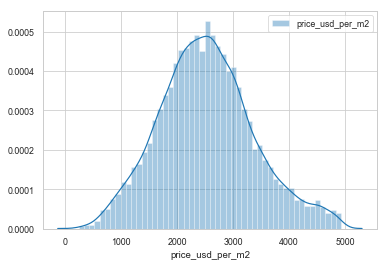

In [10]:

g = sns.distplot(df3.price_usd_per_m2, label= 'price_usd_per_m2')
plt.legend();

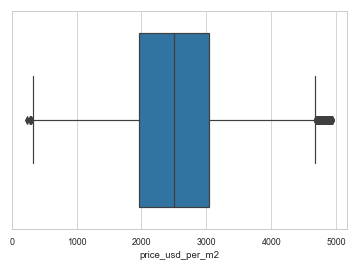

In [11]:
g2 = sns.boxplot(x=df3["price_usd_per_m2"])


Describimos nuevamente la columna mostrando sus estadísticos.

In [12]:
df3['price_usd_per_m2'].describe()

count    15131.000000
mean      2528.832243
std        847.113710
min        239.726027
25%       1956.521739
50%       2500.000000
75%       3046.153846
max       4929.577465
Name: price_usd_per_m2, dtype: float64

In [13]:
df3.shape

(15131, 16)

Vamos a seguir trabajando con el `dataframe` filtrado

In [14]:
df = df3

### Valores Faltantes

A diferencia del proyecto pasado, vamos a intentar imputar los valores faltantes para los atributos que consideramos importantes para el mercado inmobiliario. 

Estos atributos son los que informan **superficie (total o cubierta), cantidad de ambientes, precio y precio por metro cuadrado**. 

Veamos en primer lugar cuántos valores faltantes tiene cada atributo. Nos interesa verlo como un porcentaje en relación a la cantidad de observaciones. Si un atributo tiene un elevado porcentaje de faltantes, puede ser mejor no considerarlo en el análisis.

Mostramos cuál es el porcentaje de valores faltantes para cada columna.

In [15]:
df.isna().sum()

created_on                     0
operation                      0
property_type                  0
place_with_parent_names        0
lat-lon                        0
                           ...  
floor                      12668
rooms                       3426
expenses                   11866
properati_url                  0
barrio                         0
Length: 16, dtype: int64

In [16]:
percent = (df.isnull().sum()/df.isnull().count())*100
percent.sort_values(ascending=False)

floor                      83.722160
expenses                   78.421783
rooms                      22.642258
surface_covered_in_m2       3.866235
barrio                      0.000000
                             ...    
lat-lon                     0.000000
place_with_parent_names     0.000000
property_type               0.000000
operation                   0.000000
created_on                  0.000000
Length: 16, dtype: float64

Podemos ver en los resultados que los atributos `floor` y `expenses` tienen un elevado porcentaje de faltantes.  Una opción sería descartar estas columnas en el análisis. 
Si elimináramos las observaciones (filas) asociadas a estos, perderíamos el 84.79% de los datos, mermando demasiado el conjunto de datos.

Otra opción sería por ejemplo considerar categorías como faltantes o no faltantes o en todo caso analizar si hay algún patrón para poder evitar quitarlos. 

Para avanzar con el proyecto, vamos a quitar esos atributos.

In [17]:
df = df.drop(['floor', 'expenses'], axis = 1)

Analicemos estrategias para imputar los valores faltantes para los atributos `rooms`, `surface_total_in_m2` y `surface_covered_in_m2`.

Entre las opciones que tenemos está la posibilidad de imputar por alguna medida de tendencia central, como el caso de la media o la mediana. Vamos a avanzar en esa dirección.

**8) Imputar las observaciones faltantes** de la columna `surface_total_in_m2 ` y `surface_covered_in_m2` usando la **media**. 

`Scikit-learn` nos provee la clase `Imputer` que implementa las formas más comunes de imputación.

In [18]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values=np.nan, strategy='mean')
imp.fit(df[['surface_total_in_m2']])
df[['surface_total_in_m2']]=imp.transform(df[['surface_total_in_m2']])

imp2 = Imputer(missing_values=np.nan, strategy='mean')
imp2.fit(df[['surface_covered_in_m2']])
df[['surface_covered_in_m2']]=imp2.transform(df[['surface_covered_in_m2']])


df.isnull().sum()

I:\Users\franc\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
I:\Users\franc\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


created_on                    0
operation                     0
property_type                 0
place_with_parent_names       0
lat-lon                       0
                           ... 
surface_covered_in_m2         0
price_usd_per_m2              0
rooms                      3426
properati_url                 0
barrio                        0
Length: 14, dtype: int64

Una de las limitaciones que presenta este tipo de imputación es que provoca estimaciones sesgadas de la varianza. Esto impacta en los errores estandar y, por ende, en los tests estadístcos.

Este tipo de técnicas es útil cuando los valores son completamente al azar.

**Imputamos las observaciones faltantes** de la columna `rooms` usando la **mediana**.

In [19]:

imp3 = Imputer(missing_values=np.nan, strategy='median')
imp3.fit(df[['rooms']])
df[['rooms']]=imp3.transform(df[['rooms']])


df.isnull().sum()

I:\Users\franc\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


created_on                 0
operation                  0
property_type              0
place_with_parent_names    0
lat-lon                    0
                          ..
surface_covered_in_m2      0
price_usd_per_m2           0
rooms                      0
properati_url              0
barrio                     0
Length: 14, dtype: int64

### Variables binarias

#### Generar variables binarias para el atributo `property_type`.

Hay que tener en cuenta en este caso que el atributo es categórico.

Para hacerlo usando scikit-learn, por como vienen dados los valores (en formato string), primero conviene convertirlos en numéricos. Para esto usamos `LabelEncoder`.

**Convertimos** las variables de `property_type` utilizando `LabelEncoder`

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df.property_type)
df['property_type']=le.transform(df.property_type)

list(le.classes_)

['PH', 'apartment', 'house', 'store']

Luego con `OneHotEncoder` obtenemos las categorías expresadas como **variables binarias**. 

Aplicamaos `OneHotEncoder` sobre las variables categóricas para crear un dataframe `categoricals_df`

In [21]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded=le.fit_transform(df.property_type)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

[[3]
 [3]
 [3]
 ...
 [2]
 [1]
 [1]]


I:\Users\franc\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [22]:
categoricals_df=pd.DataFrame(onehot_encoded)
categoricals_df

,0,1,2,3
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
15126,0.0,1.0,0.0,0.0
15127,0.0,1.0,0.0,0.0
15128,0.0,0.0,1.0,0.0
15129,0.0,1.0,0.0,0.0


Unimos el nuevo dataframe `categorical_df` con el `dataframe` original `df`. Para esto, necesitamos que tengan el mismo índice.

In [23]:
categoricals_df = categoricals_df.set_index(df.index)
df = pd.concat([df, categoricals_df], axis=1)
df.head().T

,2,5,6,8,9
created_on,2017-08-02 00:00:00,2017-08-09 00:00:00,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-15 00:00:00
operation,sell,sell,sell,sell,sell
property_type,3,3,3,3,3
place_with_parent_names,|Argentina|Capital Federal|Palermo|Palermo Soho|,|Argentina|Capital Federal|Palermo|,|Argentina|Capital Federal|Belgrano|,|Argentina|Capital Federal|Palermo|,|Argentina|Capital Federal|Palermo|
lat-lon,"-34.589723,-58.4325664","-34.57582474,-58.43432236","-34.5739059,-58.4391946","-34.5956086,-58.4247641","-34.5580305,-58.4170088"
...,...,...,...,...,...
barrio,PALERMO,PALERMO,PALERMO,PALERMO,PALERMO
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0


### Variables calculadas

__Calculamos el precio por metro cuadrado (precio/superficie total). Llamamos a este atributo `price_m2`.__

Hay que tener cuidado en esta parte respecto de dividir por cero. Para ello, armemos una función de división que contemple eso.

El hecho de crear una columna nueva y no imputar los faltantes es simplemente una decisión. Cuando trabajemos con modelos predictivos, vamos a poder cuantificar el costo de las decisiones que tomemos en términos de performance del modelo.

In [24]:
def custom_division(x, y):
    if y > 0:
        res = x / y
    else:
        res = 0
    return res

df['price_m2'] = df.apply(lambda x: custom_division(x['price_aprox_usd'], x['surface_total_in_m2']), axis = 1)
df.drop(['price_usd_per_m2'], axis=1, inplace=True)

__Verificamos que ya no quedan atributos con valores faltantes__

In [25]:
# Creamos un dataset con los porcentajes de nulos
df_faltantes = pd.DataFrame(df.isnull().sum() / df.shape[0], columns=['Porcentaje nulos'])
# Solo mostramos los que tengan valores nulos. Si el porcentaje es 0 no se muestra
df_faltantes.loc[~(df_faltantes==0).all(axis=1)]

,Porcentaje nulos


In [26]:
print("El dataset final luego del procesamiento tiene {} observaciones".format(df.shape[0]))

El dataset final luego del procesamiento tiene 15131 observaciones


De este modo, hemos limpiado valores extremos e imputado valores nulos. El costo de esto fue la pérdida de 685 observaciones, 5% de la cantidad original de filas.